In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

## Create and Plot Pendulum Data

In [2]:
def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = 3*(1-np.cos(q)) + p**2 # pendulum hamiltonian
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0,3], timescale=15, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    
    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2.-1
    if radius is None:
        radius = np.random.rand() + 1.3 # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )
        
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])
    
    # get vector directions
    dydt = [dynamics_fn(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [3]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

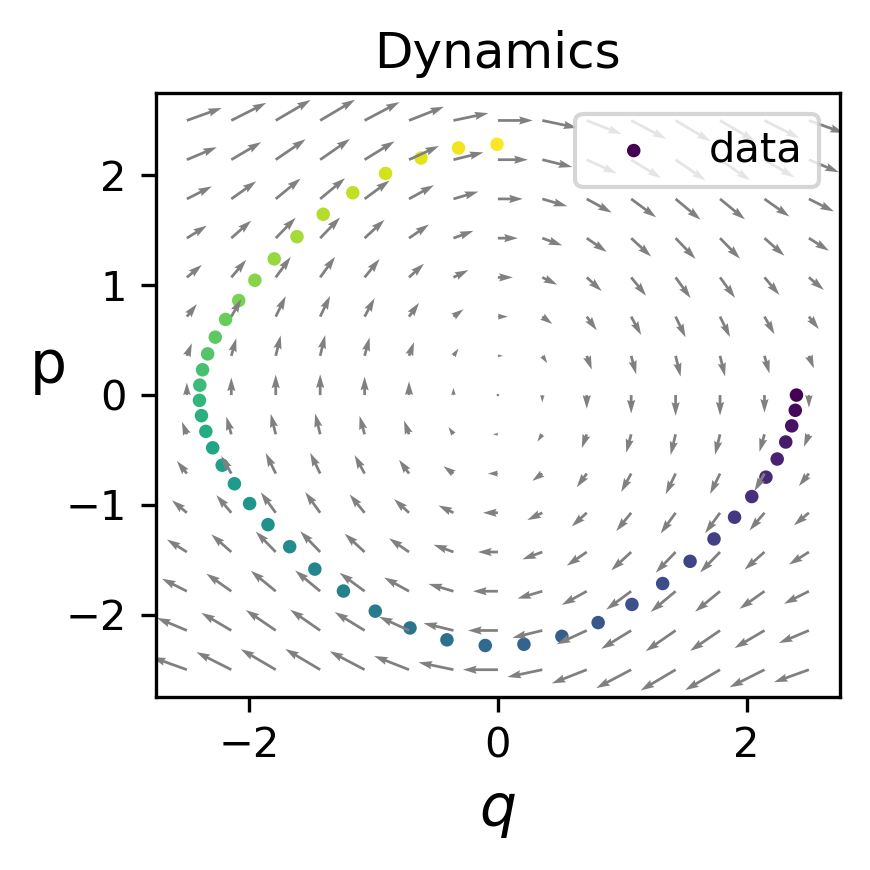

In [4]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(t_span=[0,3], radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=5, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()

## Build and Train Model

In [5]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
qp = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
dqp = torch.Tensor(data['dx'])

qp_test = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
dqp_test = torch.Tensor(data['test_dx'])

In [7]:
q_p = torch.stack([torch.tensor(x, requires_grad=True), torch.tensor(y, requires_grad=True)], dim=1)
dq_dp = torch.stack([torch.tensor(dx[0], requires_grad=True), torch.tensor(dy[0], requires_grad=True)], dim=1) 

### baseline model

In [8]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

def train(model, optimizer, loss, x, dx, epochs):
    model.train()
    for step in range(epochs):
        optimizer.zero_grad()
        x_pred = model(x)
        loss_val = loss(x_pred, dx)
        loss_val.backward()
        optimizer.step()
        
        print(f"Epoch {step+1}/{epochs} --- Train-Loss: {round(loss_val.item(), 3)}")

train(model.double(), optimizer, loss, q_p, dq_dp, 200)

Epoch 1/200 --- Train-Loss: 7.584
Epoch 2/200 --- Train-Loss: 5.48
Epoch 3/200 --- Train-Loss: 3.805
Epoch 4/200 --- Train-Loss: 2.544
Epoch 5/200 --- Train-Loss: 1.658
Epoch 6/200 --- Train-Loss: 1.09
Epoch 7/200 --- Train-Loss: 0.769
Epoch 8/200 --- Train-Loss: 0.625
Epoch 9/200 --- Train-Loss: 0.59
Epoch 10/200 --- Train-Loss: 0.612
Epoch 11/200 --- Train-Loss: 0.655
Epoch 12/200 --- Train-Loss: 0.696
Epoch 13/200 --- Train-Loss: 0.723
Epoch 14/200 --- Train-Loss: 0.731
Epoch 15/200 --- Train-Loss: 0.719
Epoch 16/200 --- Train-Loss: 0.689
Epoch 17/200 --- Train-Loss: 0.645
Epoch 18/200 --- Train-Loss: 0.591
Epoch 19/200 --- Train-Loss: 0.532
Epoch 20/200 --- Train-Loss: 0.469
Epoch 21/200 --- Train-Loss: 0.408
Epoch 22/200 --- Train-Loss: 0.352
Epoch 23/200 --- Train-Loss: 0.302
Epoch 24/200 --- Train-Loss: 0.261
Epoch 25/200 --- Train-Loss: 0.23
Epoch 26/200 --- Train-Loss: 0.208
Epoch 27/200 --- Train-Loss: 0.195
Epoch 28/200 --- Train-Loss: 0.19
Epoch 29/200 --- Train-Loss: 0.19


### HNN

In [9]:
model_HNN = MLP()
optimizer = torch.optim.Adam(model_HNN.parameters(), lr=1e-3)
loss = nn.MSELoss()

def train(model, optimizer, loss, x, dx, epochs):
    
    for step in range(epochs):
        model.train()
        optimizer.zero_grad()
        H = model(x)
        a, b = H.split(1,1)


        x_field = torch.autograd.grad(H.sum(), x, create_graph=True)[0] # gradients for field
        dH = torch.zeros_like(x_field)
        dH.T[0] = x_field.T[1]
        dH.T[1] = -x_field.T[0]

        loss_val = loss(dH, dx)
        loss_val.backward()
        optimizer.step()
        
        print(f"Epoch {step+1}/{epochs} --- Train-Loss: {round(loss_val.item(), 3)}")

train(model_HNN.double(), optimizer, loss, q_p, dq_dp, 200)

Epoch 1/200 --- Train-Loss: 6.683
Epoch 2/200 --- Train-Loss: 6.218
Epoch 3/200 --- Train-Loss: 5.771
Epoch 4/200 --- Train-Loss: 5.339
Epoch 5/200 --- Train-Loss: 4.919
Epoch 6/200 --- Train-Loss: 4.511
Epoch 7/200 --- Train-Loss: 4.116
Epoch 8/200 --- Train-Loss: 3.734
Epoch 9/200 --- Train-Loss: 3.368
Epoch 10/200 --- Train-Loss: 3.019
Epoch 11/200 --- Train-Loss: 2.689
Epoch 12/200 --- Train-Loss: 2.379
Epoch 13/200 --- Train-Loss: 2.091
Epoch 14/200 --- Train-Loss: 1.825
Epoch 15/200 --- Train-Loss: 1.582
Epoch 16/200 --- Train-Loss: 1.363
Epoch 17/200 --- Train-Loss: 1.169
Epoch 18/200 --- Train-Loss: 0.999
Epoch 19/200 --- Train-Loss: 0.854
Epoch 20/200 --- Train-Loss: 0.734
Epoch 21/200 --- Train-Loss: 0.637
Epoch 22/200 --- Train-Loss: 0.563
Epoch 23/200 --- Train-Loss: 0.507
Epoch 24/200 --- Train-Loss: 0.466
Epoch 25/200 --- Train-Loss: 0.436
Epoch 26/200 --- Train-Loss: 0.413
Epoch 27/200 --- Train-Loss: 0.393
Epoch 28/200 --- Train-Loss: 0.373
Epoch 29/200 --- Train-Loss: 

## Integration functions

In [10]:
def integrate_model_HNN(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True).view(1,2)
        pred = model.forward(x)
        pred = torch.autograd.grad(pred.sum(), x, create_graph=True)[0]
        dH = torch.zeros_like(pred)
        dH.T[0] = pred.T[1]
        dH.T[1] = -pred.T[0]
        return dH.detach().numpy()

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [11]:
def integrate_model_NN(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True).view(1,2)
        pred = model(x)
        return pred.detach().numpy()

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Calculate Trajectorys

In [12]:
# set values
q0_p0 = torch.tensor([2.4,0])
t_span = [0,200]
steps = 10000

# integrate
t = torch.linspace(t_span[0], t_span[1], steps)
x, y, dx, dy, t1 = get_trajectory(t_span=t_span, radius=2.4, y0=q0_p0.numpy(), noise_std=0, timescale=steps/t_span[1])
xHNN = integrate_model_HNN(model_HNN, t_span=t_span, y0=q0_p0, t_eval=t)
xNN = integrate_model_NN(model, t_span=t_span, y0=q0_p0, t_eval=t)

# calc gradient field
field_HNN = get_field(xmin=np.min(xHNN.y[0])-0.2, xmax=np.max(xHNN.y[0])+0.2, ymin=np.min(xHNN.y[1])-0.2, ymax=np.max(xHNN.y[1])+0.2, gridsize=15)
field_NN = get_field(xmin=np.min(xNN.y[0])-0.2, xmax=np.max(xNN.y[0])+0.2, ymin=np.min(xNN.y[1])-0.2, ymax=np.max(xNN.y[1])+0.2, gridsize=15)

## Plot Trajectorys

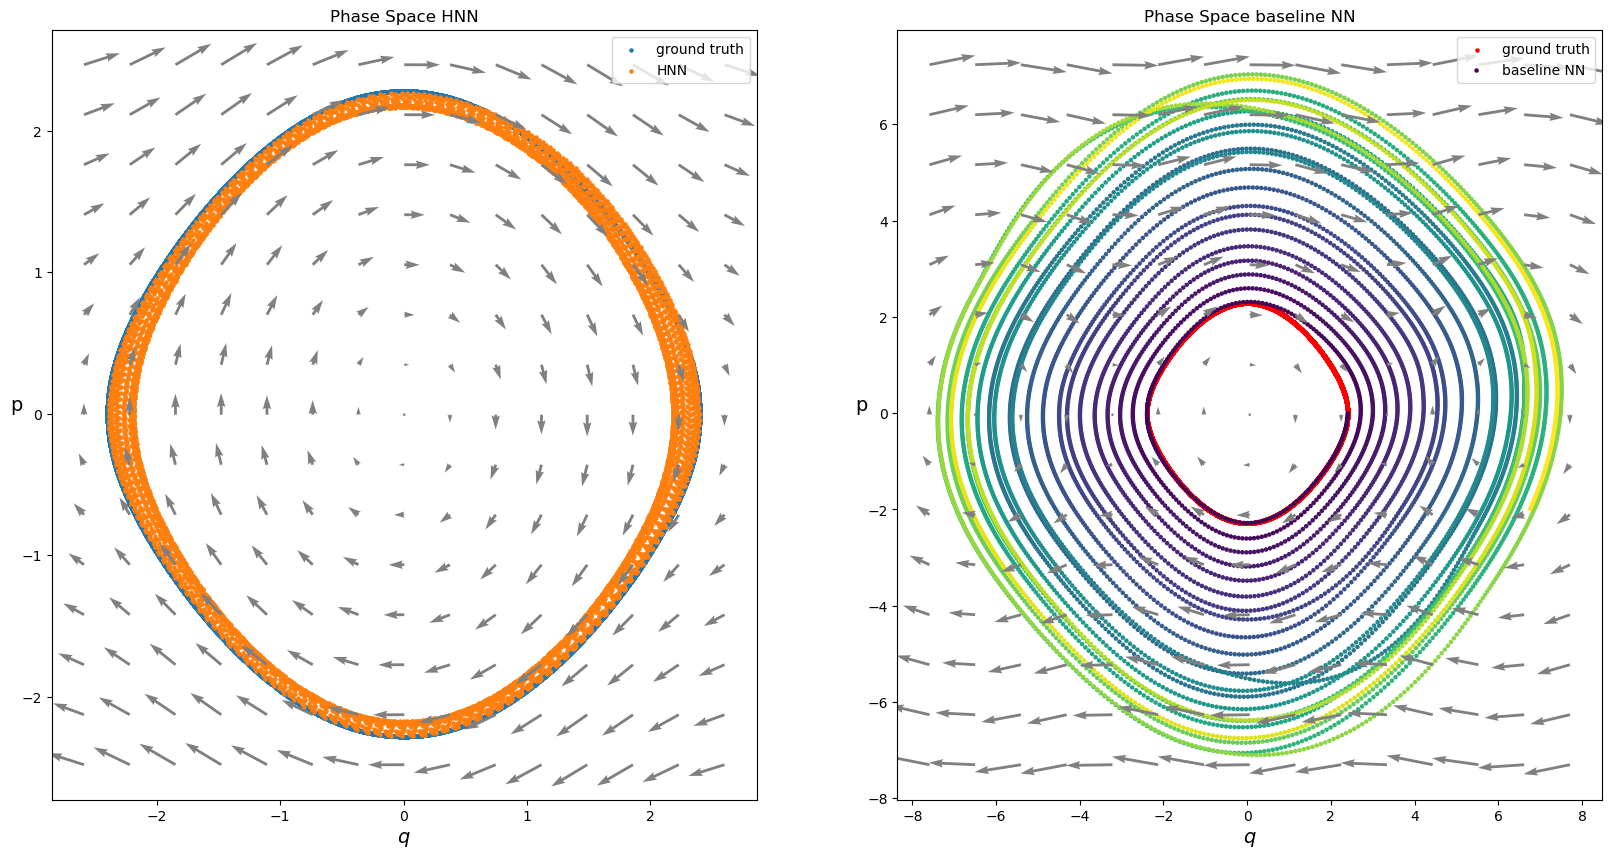

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))

# plot HNN
ax1.scatter(x,y,s=5, label='ground truth')
ax1.scatter(xHNN.y[0],xHNN.y[1], s=5, label='HNN')
ax1.quiver(field_HNN['x'][:,0], field_HNN['x'][:,1], field_HNN['dx'][:,0], field_HNN['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))

ax1.set_xlabel("$q$", fontsize=14)
ax1.set_ylabel("p", rotation=0, fontsize=14)
ax1.set_title("Phase Space HNN")
ax1.legend()

# plot baseline NN
ax2.scatter(x,y,s=5, c="red", label='ground truth')
ax2.scatter(xNN.y[0],xNN.y[1], c=t, s=5, label='baseline NN')
ax2.quiver(field_NN['x'][:,0], field_NN['x'][:,1], field_NN['dx'][:,0], field_NN['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))

ax2.set_xlabel("$q$", fontsize=14)
ax2.set_ylabel("p", rotation=0, fontsize=14)
ax2.set_title("Phase Space baseline NN")
ax2.legend()

plt.show()